# E-mail network analysis

## Mail Graph creation

### Importing the necessary packages
First of all we begin by importing the necessary packages. The necessary ones are `networkx` and `matplotlib.pyplot`. The first is used for network analysis and the second for plotting.

In [1]:
# Imports
import networkx as nx  # Core network analysis package
import numpy as np  # Core numeric package
import matplotlib.pyplot as plt  # Core plotting package
import dzcnapy_plotlib as dzcnapy  # Optional library containing pre-made plotting options
import csv  # Package for csv I/O
from collections import Counter  # Import only the Counter
from scipy.optimize import curve_fit  # Mainly to fit the degree distribution with a power-law
import pickle  # To read and write to file objects. Currently used for Girvan-Newman

# Currently unusued imports
#import warnings  # To suppress some warnings
#from multiprocessing.dummy import Pool as ThreadPool
#import powerlaw  # To test the power law distribution

In [2]:
# Options
np.set_printoptions(threshold=np.nan)  # numpy option to print all the array instead of head and tail

%config IPCompleter.greedy=True  # Auto-complete option. Press TAB to activate

### Reading data files
We open the data in csv format (list of edges representing mail communication) and create the corresponding **directed** graph, called `mail_DG`

In [3]:
with open("email-Eu-core.csv") as infile:
    csv_reader = csv.reader(infile)
    mail_DG = nx.DiGraph(csv_reader)

#print(DG.nodes(data = True))
#print(DG.edges(data = True))

Then we read the second file, which contains the department to which every node belongs, and add the information to the nodes in the graph. The result is a _directed graph_ with an attribute called `department` (with int values from 0 to 41) for each node.
There are 1005 nodes - or people - divided into 42 classes (or departments).

In [4]:
# We create a dictionary of dictionaries, having as key the node label (number between 0 and 1004)
# and with value a dictionary with the name of the attribute ('deprtment') as key and as associated value
# the department number of the node.
# NOTE: this structure is necessary because there could be more attributes, and it is required by the function
# set_node_attributes in networkx

with open("email-Eu-core-department-labels.csv") as infile:
    csv_reader = csv.reader(infile)
    attr_dict_dict = {rows[0]: {'department': int(rows[1])} for rows in csv_reader}

#print(attr_dict_dict)

In [5]:
nx.set_node_attributes(mail_DG, attr_dict_dict)

#print(DG.nodes(data = True))

###### Cleaning the graph
Let us remove the self-loops from the graph (sinche those represent the mail to one-self, irrelevant to the analysis):

In [6]:
self_loops = mail_DG.selfloop_edges()
mail_DG.remove_edges_from(self_loops)

We also create an undirected version of the graph, which might be useful for some manipulation. Note that even if the network is originally undirected, it is not necessarily true that the undirected version has no meaning.
This transposition requires a simple casting.

In [7]:
mail_G = mail_DG.to_undirected()  # Undirected version of graph used for the computation of clustering coefficient

We can see the difference in edges and degree between the original directed graph and its undirected view.

In [8]:
print("DIRECTED VERSION OF THE GRAPH:")
print(nx.info(mail_DG) + "\n")

print("UNDIRECTED VERSION:")
print(nx.info(mail_G))

DIRECTED VERSION OF THE GRAPH:
Name: 
Type: DiGraph
Number of nodes: 1005
Number of edges: 24929
Average in degree:  24.8050
Average out degree:  24.8050

UNDIRECTED VERSION:
Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16064
Average degree:  31.9682


## Department graph creation
The analysis of the department graph (based on the interactions between their elements) could be of interest.
We create the graph by adding all departments as nodes, and then adding edges between them based on the number of (undirected) edges between their elements.

In [9]:
# Graph initialization with just the departments as nodes

dep_G = nx.Graph()
for node in mail_DG.nodes(data = True):
    label, attr_dict = node
    dep_G.add_node(attr_dict["department"])
    
#print(nx.info(dep_G))

In [10]:
# For each edge in the undirected mail graph, identify the department of bot source and target
# and create an edge between those departments in the departments graph if not already existing.
# Otherwise add a weight unit to the existing edge between departments.
for edge in mail_G.edges(data=True):
    source, target, edg_attr = edge
    source_dep = attr_dict_dict[source]['department']
    targ_dep = attr_dict_dict[target]['department']
    if dep_G.has_edge(source_dep, targ_dep) == False:
        dep_G.add_edge(source_dep, targ_dep, weight = 1)
    else:
        edges = dep_G.edges
        w = edges[source_dep, targ_dep]['weight']
        dep_G.add_edge(source_dep, targ_dep, weight = w+1)

Note that the result is an undirected weighted graph with 42 nodes:

In [11]:
print(nx.info(dep_G))

Name: 
Type: Graph
Number of nodes: 42
Number of edges: 679
Average degree:  32.3333


### Graph export
To visualize the graphs, we export them in `graphml` format to import them in _Gephi_.

In [12]:
nx.write_graphml(mail_DG, "emails_w_attr_dep.graphml")
nx.write_graphml(dep_G, "departments_weighted.graphml")

## Networks Analysis

### Connected components and Giant Component
#### Mail network
First, we analyze the composition of the network by searching for the weakly and strongly connected components in the directed mail graph.
Note that, clearly, the number of weakly connected components of the directed mail graph is the same as the number of connected components of the undirected mail graph.

In [13]:
n_weak_conn_comp = nx.number_weakly_connected_components(mail_DG)
n_strong_conn_comp = nx.number_strongly_connected_components(mail_DG)
n_conn_comp = nx.number_connected_components(mail_G)

print("# of connected components (undirected version of the graph): " + str(n_conn_comp))
print("# of weakly connected components:                            " + str(n_weak_conn_comp))
print("# of strongly connected components:                          " + str(n_strong_conn_comp))

# of connected components (undirected version of the graph): 20
# of weakly connected components:                            20
# of strongly connected components:                          203


Is there a giant component in the graph?
First we check the undirected graph (which has only {{n_conn_comp}} components)

In [14]:
# Create the array of UNDIRECTED connected components (subgraphs)
connected_components_generator = (mail_G.subgraph(c) for c in nx.connected_components(mail_G))
conn_comp_arr = np.array(list(connected_components_generator))

# Compute total size and order to calculate the proportion in the components
tot_nodes_n = mail_G.order()
tot_undirected_edges_n = mail_G.size()

# Initialize variables to search for the biggest component:
max_order = 0
max_order_index = 0  # Initialization for the variable which will contain the position of the component with highest order

HEAD_INDEX = 1  # For printing purposes - Constant
tail_index = len(conn_comp_arr) - 1  # For printing purposes - to be adapted 

# Scan through components, find the one with max order and print some info for the first bunch
for (i, component) in zip(range(len(conn_comp_arr)), conn_comp_arr):
    n_nodes_comp = component.order()
    n_directed_edges_comp = component.size()   
    
    if n_nodes_comp > max_order:
        max_order = n_nodes_comp
        max_order_index = i
    
    relative_order = n_nodes_comp/tot_nodes_n
    relative_size = n_directed_edges_comp/tot_undirected_edges_n
    
    if i <= HEAD_INDEX or i >= tail_index:
        print("COMPONENT #" + str(i) + ":")
        print("# of nodes: " + str(n_nodes_comp))
        print("# of edges: " + str(n_directed_edges_comp))
        print("Relative Order (proportion of nodes):", relative_order)
        print("Relative Size (proportion of edges):", relative_size)
        print()
    if i == HEAD_INDEX:
        print("...\n")

COMPONENT #0:
# of nodes: 986
# of edges: 16064
Relative Order (proportion of nodes): 0.981094527363184
Relative Size (proportion of edges): 1.0

COMPONENT #1:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

...

COMPONENT #19:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0



Yes.
The other 19 components are actually isolated nodes that communicate at most with themselves (self-loops).
Then we hope to find also a strongly connected giant component in the directed graph (which has {{n_strong_conn_comp}} components):

In [15]:
# Create the array of components (subgraphs)
strongly_connected_components_generator = (mail_DG.subgraph(c) for c in nx.strongly_connected_components(mail_DG))
str_conn_comp_arr = np.array(list(strongly_connected_components_generator))

# Compute total size and order to see the proportion in the components
tot_nodes_n = mail_DG.order()
tot_directed_edges_n = mail_DG.size()

# Initialize variables to search for the biggest component:
max_directed_order = 0
max_directed_order_index = 0

HEAD_INDEX = 1  # For printing purposes - Constant
tail_index = len(str_conn_comp_arr) - 1  # For printing purposes - to be adapted 

# Scan through components, find the one with max order and print some info for the first bunch
for (i, component) in zip(range(len(str_conn_comp_arr)), str_conn_comp_arr):
    n_nodes_comp = component.order()
    n_directed_edges_comp = component.size()   
    
    if n_nodes_comp > max_directed_order:
        max_directed_order = n_nodes_comp
        max_directed_order_index = i
    
    relative_order = n_nodes_comp/tot_nodes_n
    relative_size = n_directed_edges_comp/tot_directed_edges_n
    
    if i <= HEAD_INDEX or i >= tail_index:
        print("COMPONENT #" + str(i) + ":")
        print("# of nodes: " + str(n_nodes_comp))
        print("# of edges: " + str(n_directed_edges_comp))
        print("Relative Order (proportion of nodes):", relative_order)
        print("Relative Size (proportion of edges):", relative_size)
        print()
    if i == HEAD_INDEX:
        print("...\n")
    if n_nodes_comp > 1:
        print("COMPONENT #" + str(i) + ":")
        print("# of nodes: " + str(n_nodes_comp))
        print("# of edges: " + str(n_directed_edges_comp))
        print("Relative Order (proportion of nodes):", relative_order)
        print("Relative Size (proportion of edges):", relative_size)
        print("...\n")

COMPONENT #0:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

COMPONENT #1:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

...

COMPONENT #162:
# of nodes: 803
# of edges: 24138
Relative Order (proportion of nodes): 0.7990049751243781
Relative Size (proportion of edges): 0.9682698864775964
...

COMPONENT #202:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0



In this case, too, we gladly find that there is a single giant strongly connected component with {{max_directed_order}} nodes, while the other {{n_strong_conn_comp-1}} components are just single nodes.

In [16]:
# Saving the giant components (both directed and undirected) with simple variable names
giant_component_mail_G = conn_comp_arr[max_order_index]
gc_mail_G = giant_component_mail_G

strong_giant_component_mail_DG = str_conn_comp_arr[max_directed_order_index]
sgc_mail_DG = strong_giant_component_mail_DG

For the analysis of the mail network, we can in some instances use just the giant component. This will enable us to find measures like distances without risking to find infinite-length (not connected) paths.

### Measures - degree

We first extrapolate the degree of all nodes in the original directed graph, we find the max, we compute the frequency for each degree..

In [17]:
node_and_degrees = mail_DG.degree  # Iterator over 2-tuples (node, degree)

node_degrees = np.array(list(deg for _, deg in mail_DG.degree))  # Array of degrees

In [18]:
# Count the number of nodes for each degree
deg_counter = Counter(node_degrees)

# Create the array of the existing degrees and the array of corresponding number
degrees = np.array(sorted(deg_counter.keys()))
deg_n = np.array(list(deg_counter[deg] for deg in degrees))

# Find and print the maximum degree
max_degree = max(degrees)
print("Max degree: " + str(max_degree))

# Compute the log of both arrays, to verify the power law
mask_not_null = np.all([degrees != 0, deg_n != 0], axis = 0)  # Make sure to take only values > 0, since we are applying the log
log_degrees = np.log(degrees[mask_not_null])
log_deg_n = np.log(deg_n[mask_not_null])

Max degree: 544


..and then we plot the distribution.

In [19]:
# Definition of functions for fitting the distribution of 
def power(x, c, k):
    return c*(x**(-k))

def linear(x, m, c):
    return m*x + c

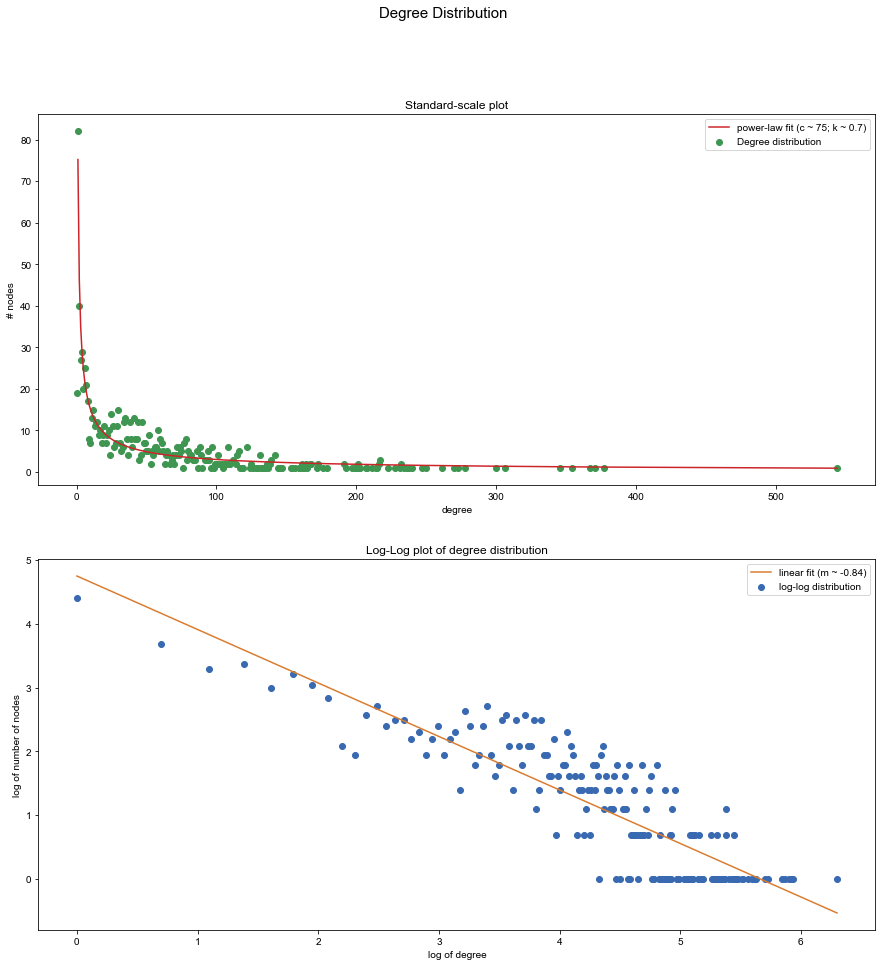

In [20]:
# Create a Figure divided in two Axes (subplots)
fig, (ax, ax_log) = plt.subplots(2, 1)
fig.set_size_inches(15, 15)
fig.suptitle("Degree Distribution", fontsize = 15)

# In the first Axis draw the standard-scale distribution of degrees
ax.set_xlabel('degree')
ax.set_ylabel('# nodes')
ax.set_title("Standard-scale plot")
ax.scatter(degrees, deg_n, marker = 'o', facecolors='#3e9651', edgecolors='#3e9651', label = 'Degree distribution')
pow_params = curve_fit(power, degrees[1:], deg_n[1:])
ax.plot(degrees[1:], power(degrees[1:], *pow_params[0]), color='#cc2529', label = 'power-law fit (c ~ '+format(pow_params[0][0], '.2g')+'; k ~ '+format(pow_params[0][1], '.2g')+')')
ax.legend()

# In the second Axis draw the log-log distribution of degrees
ax_log.set_xlabel('log of degree')
ax_log.set_ylabel('log of number of nodes')
ax_log.set_title("Log-Log plot of degree distribution")
ax_log.scatter(log_degrees, log_deg_n, marker = 'o', facecolors='#396ab1', edgecolors='#396ab1', label = 'log-log distribution')
lin_params = curve_fit(linear, log_degrees, log_deg_n)
ax_log.plot(log_degrees, linear(log_degrees, *lin_params[0]), color='#da7c30', label='linear fit (m ~ '+format(lin_params[0][0], '.2g')+')')
ax_log.legend()

# Save the figure as png and plot it
plt.savefig("degree_distribution.png")
plt.show()

We note that the distribution of the degrees in the whole graph roughly follows a power-law.
If we decided to only consider the degrees of nodes included in the giant strongly connected component, we would find that it probably wouldn't follow a power-law.

Computing the average degree we get the sum of average in-degree and average out-degree, as expected.

In [21]:
avg_deg = np.mean(node_degrees)
var_deg = np.var(node_degrees)
std_deg = np.std(node_degrees)

print("Average degree: " + str(avg_deg))
print("Variance of degree distribution: " + str(var_deg))

Average degree: 49.6099502488
Variance of degree distribution: 3570.01104527


The degree distribution seems to roughly satisfy a power-law, hence we can say that the network is scale-free.

### Measures - distances
#### SGC
We compute the distribution of the distances and relevant statistics. For that we use the giant strongly connected component.

In [22]:
def distance_distribution(DG, plotsave=None):
    nodes = DG.nodes()

    distances = []
    for node in nodes:
        distances = distances + list((nx.shortest_path_length(DG, source = node)).values())
    
    diameter = max(distances)

    distances = np.array(distances)
    dist_freq = Counter(distances)
    
    dist_freq = np.array(list(dist_freq.values()))
    dist_freq[0] = 0  # In the computation of statistics we exclude null distances since they mean nothing
    
    # If the graph is undirected, halve the distances since they are counted twice in the step before
    if isinstance(DG, nx.classes.graphviews.SubGraph):
        for i in range(len(dist_freq)):
            dist_freq[i] /= 2
            
    plt.plot(dist_freq, linestyle='dotted', color = 'red')
    plt.scatter(range(len(dist_freq)), dist_freq, linestyle='dotted', color = 'blue')
    if plotsave is not None:
        plt.savefig(plotsave)
    
    return np.average(distances), np.std(distances)

Average distance in the strongly connected component: 2.54431002049
Standard deviation of distance in the strongly connected component: 0.67575449108


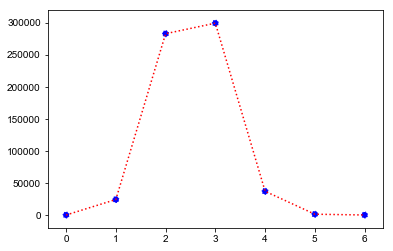

In [23]:
sgc_avg_dist, sgc_std_dist = distance_distribution(sgc_mail_DG, "distance_distributionDG.png")
print("Average distance in the strongly connected component: " + str(sgc_avg_dist))
print("Standard deviation of distance in the strongly connected component: " + str(sgc_std_dist))

#### GC
Then we can check the distance distribution and statistics for the giant connected component of the undirected version of the graph:

Average distance in the connected component: 2.58431015968
Standard deviation of distance in the connected component: 0.697027202662


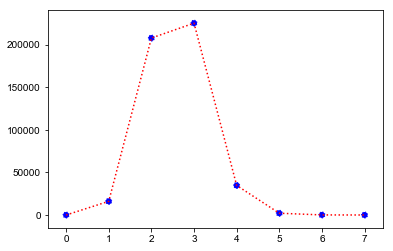

In [24]:
avg_dist, std_dist = distance_distribution(gc_mail_G, "distance_distributionG.png")
print("Average distance in the connected component: " + str(avg_dist))
print("Standard deviation of distance in the connected component: " + str(std_dist))

We can then check the eccentricities of the nodes. The lowest eccentricity represent the radius and the highest, the diameter.

Noting that the computation of eccentricities requires a connected graph (otherwise, the distance measures would be infinite), we first check the stong giant component of the directed graph:

In [25]:
# Compute the radius and the diameter:
sgc_eccentricities = nx.eccentricity(sgc_mail_DG)
sgc_radius = min(sgc_eccentricities.values())  # Manual radius
sgc_diameter = max(sgc_eccentricities.values())  # Manual diameter

print("Radius of the giant strongly connected component: " + str(sgc_radius))
print("Diameter of the giant strongly connected component: " + str(sgc_diameter))

Radius of the giant strongly connected component: 3
Diameter of the giant strongly connected component: 6


Then we check also the giant component of the undirected graph to see if (and how) the distance measures change.

In [26]:
gc_eccentricities = nx.eccentricity(gc_mail_G)
gc_radius = min(gc_eccentricities.values())  # Manual radius
gc_diameter = max(gc_eccentricities.values())  # Manual diameter

In [27]:
print("Radius of the giant connected component: " + str(gc_radius))
print("Diameter of the giant connected component: " + str(gc_diameter))

Radius of the giant connected component: 4
Diameter of the giant connected component: 7


We see that the giant strongly connected component (with ~80% of the nodes of the whole graph) effectively has a smaller radius and diameter than the giant connected component of the undirected graph (which has ~98% of the nodes).

### Centrality
#### Degree centrality
We analyze the degree centrality of all the nodes in the graph and search for a _particularly central_ node:

In [28]:
dict1 = nx.degree_centrality(mail_DG)
l = []
for key, value in dict1.items():
    department = mail_DG.nodes(data=True)[key]['department']
    l.append((key, department, value))

sorted_deg_cent_arr = np.array(sorted(l, key=lambda x: x[2], reverse = True))
central_node = int(sorted_deg_cent_arr[0][0])
central_node_dep = int(sorted_deg_cent_arr[0][1])

print(sorted_deg_cent_arr)
print("The node with highest degree centrality is #" + str(central_node) + ", belonging to department " + str(central_node_dep))

[['160' '36' '0.5418326693227091']
 ['121' '36' '0.3754980079681275']
 ['107' '36' '0.3695219123505976']
 ['62' '36' '0.3655378486055777']
 ['86' '36' '0.35258964143426297']
 ['82' '36' '0.3446215139442231']
 ['434' '34' '0.3047808764940239']
 ['183' '4' '0.29880478087649404']
 ['5' '25' '0.27689243027888444']
 ['129' '4' '0.27191235059760954']
 ['249' '14' '0.2689243027888446']
 ['211' '22' '0.2599601593625498']
 ['166' '36' '0.24900398406374502']
 ['64' '25' '0.24601593625498008']
 ['128' '5' '0.23904382470119523']
 ['21' '9' '0.23705179282868524']
 ['283' '36' '0.23505976095617528']
 ['114' '10' '0.23306772908366533']
 ['87' '34' '0.23107569721115537']
 ['105' '34' '0.23107569721115537']
 ['13' '26' '0.2300796812749004']
 ['106' '38' '0.22709163346613545']
 ['282' '36' '0.22211155378486055']
 ['142' '36' '0.21613545816733068']
 ['333' '10' '0.21613545816733068']
 ['377' '7' '0.21613545816733068']
 ['58' '21' '0.2151394422310757']
 ['63' '21' '0.2151394422310757']
 ['420' '26' '0.214

We found that node {{central_node}} is quite the central one.
Moreover, by visual inspection of the sorted list of nodes (by centrality), we can see that most of the most central ones belong to department {{central_node_dep}}.

#### Eigenvector centrality

In [29]:
dict1 = nx.eigenvector_centrality(mail_DG)
l = []
for key, value in dict1.items():
    department = mail_DG.nodes(data=True)[key]['department']
    l.append((key, department, value))

sorted_deg_cent_arr = np.array(sorted(l, key=lambda x: x[2], reverse = True))
central_node = int(sorted_deg_cent_arr[0][0])
central_node_dep = int(sorted_deg_cent_arr[0][1])

print(sorted_deg_cent_arr)
print("The node with highest eigenvector centrality is #" + str(central_node) + ", belonging to department " + str(central_node_dep))

[['160' '36' '0.1489839610022106']
 ['107' '36' '0.14348951067384297']
 ['62' '36' '0.13989901304591137']
 ['434' '34' '0.13593184293414826']
 ['121' '36' '0.13592230115754597']
 ['183' '4' '0.1258339823031557']
 ['128' '5' '0.12008197810045983']
 ['256' '4' '0.1167375166095992']
 ['249' '14' '0.11540507049532335']
 ['129' '4' '0.11526957279516155']
 ['82' '36' '0.1121028824617795']
 ['283' '36' '0.11163469910650066']
 ['114' '10' '0.10921392707727051']
 ['87' '34' '0.1090481478057027']
 ['106' '38' '0.10863233297089901']
 ['166' '36' '0.10770297773297173']
 ['211' '22' '0.10692440234619256']
 ['105' '34' '0.10628496689734576']
 ['212' '34' '0.10469564042680932']
 ['169' '13' '0.10099268524989688']
 ['115' '13' '0.10037092721442546']
 ['86' '36' '0.09944639849896476']
 ['280' '4' '0.09655930418488469']
 ['28' '11' '0.09620991060445867']
 ['63' '21' '0.09530449484069071']
 ['81' '15' '0.09506502772042409']
 ['21' '9' '0.0948793355463515']
 ['282' '36' '0.09443673806322561']
 ['64' '25' 

#### Closeness Centrality

In [30]:
dict1 = nx.closeness_centrality(mail_DG)
l = []
for key, value in dict1.items():
    department = mail_DG.nodes(data=True)[key]['department']
    l.append((key, department, value))

sorted_deg_cent_arr = np.array(sorted(l, key=lambda x: x[2], reverse = True))
central_node = int(sorted_deg_cent_arr[0][0])
central_node_dep = int(sorted_deg_cent_arr[0][1])

print(sorted_deg_cent_arr)
print("The node with highest eigenvector centrality is #" + str(central_node) + ", belonging to department " + str(central_node_dep))

[['160' '36' '0.4496688397114823']
 ['62' '36' '0.4367960817756949']
 ['107' '36' '0.43313263076725356']
 ['434' '34' '0.42843368072064014']
 ['121' '36' '0.42761501763646054']
 ['86' '36' '0.423034390478414']
 ['64' '25' '0.4214410406084389']
 ['129' '4' '0.4190733943128858']
 ['183' '4' '0.4185508589085057']
 ['128' '5' '0.41725020366018833']
 ['166' '36' '0.41544280797601674']
 ['82' '36' '0.41365100288924406']
 ['105' '34' '0.412634036686689']
 ['249' '14' '0.4123805759761935']
 ['87' '34' '0.40886454183266935']
 ['106' '38' '0.4086156894030694']
 ['283' '36' '0.4086156894030694']
 ['5' '25' '0.4076233015720966']
 ['256' '4' '0.4061437251598567']
 ['212' '34' '0.405163293717105']
 ['420' '26' '0.40443107089713437']
 ['211' '22' '0.40321656317672255']
 ['301' '26' '0.4029745364281171']
 ['21' '9' '0.4022501963386717']
 ['142' '36' '0.4022501963386717']
 ['114' '10' '0.40009271614376823']
 ['282' '36' '0.3993786898805729']
 ['280' '4' '0.3979582558916675']
 ['81' '15' '0.397722498631

#### Betweenness Centrality

In [31]:
dict1 = nx.betweenness_centrality(mail_DG)
l = []
for key, value in dict1.items():
    department = mail_DG.nodes(data=True)[key]['department']
    l.append((key, department, value))

sorted_deg_cent_arr = np.array(sorted(l, key=lambda x: x[2], reverse = True))
central_node = int(sorted_deg_cent_arr[0][0])
central_node_dep = int(sorted_deg_cent_arr[0][1])

print(sorted_deg_cent_arr)
print("The node with highest eigenvector centrality is #" + str(central_node) + ", belonging to department " + str(central_node_dep))

[['160' '36' '0.07212078608028884']
 ['86' '36' '0.037432912122184775']
 ['5' '25' '0.026984804243671952']
 ['121' '36' '0.024532102889508717']
 ['62' '36' '0.02451110558180135']
 ['107' '36' '0.02185778938072534']
 ['64' '25' '0.01866532308007618']
 ['82' '36' '0.018229609890582157']
 ['377' '7' '0.016220465196907407']
 ['129' '4' '0.015569466534401019']
 ['183' '4' '0.0149555521023646']
 ['434' '34' '0.014775207960301401']
 ['166' '36' '0.013955522976033403']
 ['211' '22' '0.013691702622698783']
 ['533' '35' '0.012892237833093335']
 ['21' '9' '0.012649398528524305']
 ['6' '25' '0.01263418606426239']
 ['44' '14' '0.011807492994911283']
 ['333' '10' '0.011492938932395691']
 ['301' '26' '0.011379787356608823']
 ['13' '26' '0.010797965523745076']
 ['820' '5' '0.010587844938496736']
 ['96' '20' '0.010283812073512854']
 ['128' '5' '0.010041832893355892']
 ['420' '26' '0.009433998418109565']
 ['106' '38' '0.009330466439953384']
 ['249' '14' '0.00914498584009736']
 ['411' '28' '0.00849174176

#### Harmonic Centrality

In [32]:
dict1 = nx.harmonic_centrality(mail_DG)
l = []
for key, value in dict1.items():
    department = mail_DG.nodes(data=True)[key]['department']
    l.append((key, department, value))

sorted_deg_cent_arr = np.array(sorted(l, key=lambda x: x[2], reverse = True))
central_node = int(sorted_deg_cent_arr[0][0])
central_node_dep = int(sorted_deg_cent_arr[0][1])

print(sorted_deg_cent_arr)
print("The node with highest eigenvector centrality is #" + str(central_node) + ", belonging to department " + str(central_node_dep))

[['160' '36' '505.74999999999886']
 ['62' '36' '487.33333333333195']
 ['107' '36' '481.8333333333319']
 ['121' '36' '474.66666666666515']
 ['434' '34' '473.2499999999987']
 ['86' '36' '470.7499999999982']
 ['183' '4' '464.6666666666649']
 ['64' '25' '463.7499999999984']
 ['129' '4' '463.4166666666649']
 ['128' '5' '459.9166666666649']
 ['166' '36' '457.08333333333155']
 ['82' '36' '453.91666666666487']
 ['106' '38' '453.16666666666447']
 ['105' '34' '451.24999999999824']
 ['5' '25' '451.16666666666447']
 ['283' '36' '450.3333333333312']
 ['249' '14' '450.166666666665']
 ['256' '4' '447.91666666666436']
 ['87' '34' '446.5833333333313']
 ['211' '22' '446.16666666666424']
 ['301' '26' '445.3333333333309']
 ['420' '26' '444.1666666666644']
 ['21' '9' '443.0833333333309']
 ['212' '34' '441.4999999999979']
 ['114' '10' '440.9166666666641']
 ['282' '36' '439.5833333333307']
 ['142' '36' '438.9166666666644']
 ['280' '4' '437.7499999999974']
 ['115' '13' '435.9999999999974']
 ['820' '5' '434.99

We can also see some centrality measure for the betweenness of the graph of departments

In [33]:
print("betweenness of departments:", str(nx.betweenness_centrality(dep_G, normalized = False)))

betweenness of departments: {1: 10.190677776183604, 21: 8.357407430021457, 25: 4.638564501090789, 14: 6.467265077770905, 9: 5.283051647582242, 26: 12.021258306764135, 4: 45.23643002445133, 17: 1.9643378536985068, 34: 10.190677776183604, 11: 4.716423836077672, 5: 0.8561535179054752, 10: 10.49740209761381, 36: 18.32401110951694, 37: 8.161065340688815, 7: 6.644448676479272, 22: 3.328023220967801, 8: 6.383421688169675, 15: 16.044671005176838, 3: 0.063894523326572, 29: 0.6350262796043239, 20: 1.4588673768119576, 16: 0.8528909672516203, 38: 8.80646434599494, 27: 0.6541513393699301, 13: 3.697402097613807, 6: 3.549941731734722, 0: 1.4259789903396434, 28: 2.6135722976192213, 2: 1.3353157916947003, 40: 2.5965002412478912, 35: 6.467265077770905, 23: 1.9350864023289867, 19: 5.33839449247591, 24: 0.2975606909430438, 32: 1.371053756740273, 31: 0.09637605042016806, 39: 0.28983928719703245, 12: 0.1421630874572051, 30: 0.06696428571428571, 41: 0.0, 18: 0.0, 33: 0.0}


### Clustering coefficient - whole graph
First, we compute the average clustering coefficient for the whole graph. Note that in order to do this we need to use the undirected version.

In [34]:
avg_clustering = nx.average_clustering(mail_G)
print("Averge clustering for undirected graph: " + str(avg_clustering))

Averge clustering for undirected graph: 0.3993549664221539


Then we might want to check the clustering coefficient of the most central node ({{central_node}}):

In [35]:
print("Clustering of central node (" + str(central_node) + "): " + str(nx.clustering(mail_G, str(central_node))))

Clustering of central node (160): 0.09351196494775868


We then check the clustering coefficient for a natural division of the graph: the departments.

In [36]:
# Define function for computing average clustering for 42 departments
def department_clustering(DG):
    
    nodes = DG.nodes(data = True)

    listona = []
    for i in range(42):
        listona.append(DG.subgraph([n for n, attrdict in DG.node.items() if attrdict['department'] == i]))

    avg_clust_dep = np.zeros(42)
    for i in range(42):
        if len(listona[i].nodes()) != 0:
            avg_clust_dep[i] = nx.average_clustering(listona[i].to_undirected())
        else:
            avg_clust_dep[i] = None
    
    return avg_clust_dep

In [37]:
avg_clust_dep = department_clustering(mail_DG)

for i in range(42):
    print("Avg clustering coefficient for department " + str(i) + ": " + str(avg_clust_dep[i]))

Avg clustering coefficient for department 0: 0.532740541768
Avg clustering coefficient for department 1: 0.551954053034
Avg clustering coefficient for department 2: 0.69619047619
Avg clustering coefficient for department 3: 0.666335978836
Avg clustering coefficient for department 4: 0.435968529458
Avg clustering coefficient for department 5: 0.815425315425
Avg clustering coefficient for department 6: 0.0892857142857
Avg clustering coefficient for department 7: 0.693027575469
Avg clustering coefficient for department 8: 0.732125915021
Avg clustering coefficient for department 9: 0.436185168998
Avg clustering coefficient for department 10: 0.67502617076
Avg clustering coefficient for department 11: 0.825560036394
Avg clustering coefficient for department 12: 1.0
Avg clustering coefficient for department 13: 0.789684660752
Avg clustering coefficient for department 14: 0.503132497705
Avg clustering coefficient for department 15: 0.589892702789
Avg clustering coefficient for department 16: 

It seems that most departments are clustered above the average of the graph.

In [38]:
# Girvan-Newman is commented because it would require too much time. Let us export and import the generated list with pickle

#sets_of_components_gen = nx.algorithms.community.centrality.girvan_newman(sgc_mail_DG)
#list_sets_components = []
#i = 0
#for component in sets_of_components_gen:
#    list_sets_components.append(component)
#    print("Iteration #" + str(i) + ":\t\tNumber of components: " + str(len(component)))
#    if i > 42:
#        break
#    i += 1
with open('girvan_newman_list.obj', 'rb') as infile:
    list_sets_components = pickle.load(infile)

#with open('girvan_newman_list.obj', 'wb') as outfile:
#    pickle.dump(list_sets_components, outfile)

### Homophily
We want to check homophily with respect to departments.
First, we estimate the probability that two nodes belong to the same department

In [39]:
# Compute the number of nodes for each department
nodes = mail_G.nodes(data=True)
n_nodes_per_dep = np.zeros(42)
for i, node in zip(range(len(mail_G.nodes(data=True))), mail_G.nodes(data=True)):
    num, dicti = node
    n_nodes_per_dep[dicti['department']] += 1

# Estimate the probability of being in dep i as the frequence of nodes belonging to dep i
freq_dep = n_nodes_per_dep/len(mail_G.nodes(data=True))

In [40]:
# Compute the probability of being in the same department and of being in a different one
prob_same_dep = sum(freq_dep**2)
prob_diff_dep = 1-prob_same_dep

Then we compare it with the actual frequence of pairs of nodes belonging to the same department

In [41]:
diff_dep = 0
for edge in mail_G.edges(data=True):
    source, target, _ = edge
    src_dep = mail_G.nodes[source]['department']
    trg_dep = mail_G.nodes[target]['department']
    if (src_dep is not trg_dep):
        diff_dep += 1

freq_diff_dep = diff_dep/len(mail_G.edges())
freq_same_dep = 1- freq_diff_dep

In [42]:
print("Estimated probability that a couple of nodes belong to the same department in absence of homophily: " + format(prob_same_dep))
print("Estimated probability that a couple of nodes belong to the same department in absence of homophily: " + format(freq_same_dep))

Estimated probability that a couple of nodes belong to the same department in absence of homophily: 0.04761565307789413
Estimated probability that a couple of nodes belong to the same department in absence of homophily: 0.3357196215139442


We see that the estimated probability in a random graph (without homophily) is much lower than the actual frequence of pairs of nodes belonging to the same department.

### Density
We compute the density of both the mail and department networks

In [43]:
print("density of email network:", str(nx.density(mail_DG)))
print("density of department network:", str(nx.density(dep_G)))

density of email network: 0.024706150522288955
density of department network: 0.7886178861788617


### Assortativity

In [44]:
lista = nx.degree(mail_DG)
assortativity = np.zeros(len(degrees))
avg_neighbor_deg = nx.average_neighbor_degree(mail_DG, source = 'out', target = 'out')
for i, deg in zip(range(len(degrees)), degrees):
    assortativity[i] = np.mean([avg_neighbor_deg[node_str] for node_str, degree in lista if degree == deg])

Degree Assortativity Coefficient: -0.013708196001959577


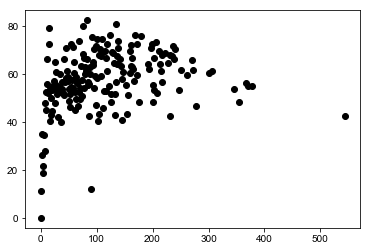

In [45]:
print("Degree Assortativity Coefficient: " + format(nx.degree_assortativity_coefficient(mail_DG), ''))
plt.figure(1)
plt.scatter(degrees, assortativity)
plt.savefig("assortativity.png")

It is apparent that there is almost no assortativity. Maybe just a bit for the first few degrees.

# END